## This notebook is a test of a 50% dataset to make sure this AWS instance will run and save a finished model

In [4]:
!cd /Data-Science/Data

/bin/sh: 1: cd: can't cd to /Data-Science/Data


In [5]:
import numpy as np, pandas as pd
import warnings
import psutil, os
warnings.filterwarnings('ignore')

# X_train = pd.read_csv('X_train.csv')
# y_train = pd.read_csv('y_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_test = pd.read_csv('y_test.csv')

# X_train = pd.read_csv('X_train_small.csv')
# y_train = pd.read_csv('y_train_small.csv')
# X_test = pd.read_csv('X_test_small.csv')
# y_test = pd.read_csv('y_test_small.csv')

X_train = pd.read_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/X_train_full.pkl')
y_train = pd.read_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/y_train_full.pkl')
X_test = pd.read_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/X_test_full.pkl')
y_test = pd.read_pickle('/home/nedderlander/datascience/burn notice/Data-Science/Data/y_test_full.pkl')

In [4]:
!pip install category-encoders

    100% |████████████████████████████████| 92kB 5.3MB/s ta 0:00:011
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
# X_train.drop(columns='DATE', inplace=True)
# X_test.drop(columns='DATE', inplace=True)

In [7]:
# Now I'll set up pipelines

# scikit-learn pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# feature processing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# pre-processing pipeline
column_trans = ColumnTransformer(
    [('onehot', ce.OneHotEncoder(), ['satellite', 'daynight', 'type']),
    ('scale', StandardScaler(), ['brightness', 'track', 'scan', 'acq_time', 'confidence', 'bright_t31', 'frp'])],
    remainder='passthrough')

# preprocess = make_pipeline(column_trans, FunctionTransformer(all_float_to_int))
# # , 
# #                            FunctionTransformer(downcast_all, "float"),
# #                           FunctionTransformer(downcast_all, "integer"),
# #                           FunctionTransformer(downcast_all, target_type = "unsigned", 
# #                            inital_type = "integer"))


In [8]:
# try to tune RFC with timeseries split
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

random_state = 314

tscv = TimeSeriesSplit(n_splits=5)

model =  make_pipeline(column_trans, DecisionTreeClassifier(random_state = random_state ))

dtc_hyperparameters = { 
    'decisiontreeclassifier__criterion' : ['gini', 'entropy'],
    'decisiontreeclassifier__max_features' : ['auto', 'log2', None],
    'decisiontreeclassifier__min_samples_leaf' : [1, 2, 3, 5, 10],
    'decisiontreeclassifier__min_samples_split' : [2,5,10]
}

search = RandomizedSearchCV(estimator=model, cv=tscv, scoring='roc_auc', n_iter=20,
                           param_distributions=dtc_hyperparameters, n_jobs=-1, verbose=10)
search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehot', OneHotEncoder(cols=None, drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_...       min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best'))]),
          fit_params=None, iid='warn', n_iter=20, n_jobs=-1,
          param_distributions={'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_features': ['auto', 'log2', None], 'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 5, 10], 'decisiontreeclassifier__min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='wa

In [9]:
search.score(X_test, y_test)

0.6494101730454533

In [11]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

y_pred_proba = search.predict_proba(X_test)[:,1]
y_pred = search.predict(X_test)
print('ROC: ', roc_auc_score(y_test, y_pred_proba))
print('f1: ', roc_auc_score(y_test, y_pred))


ROC:  0.6494101730454533
f1:  0.5999447964686503


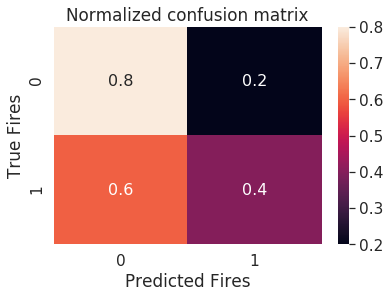

In [34]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred) 
#normalize cm
array = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})#.set_title('Normalized confusion matrix')# font size
ax.set(xlabel='Predicted Fires', ylabel='True Fires', title = 'Normalized confusion matrix')
plt.show()

In [10]:
results = pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decisiontreeclassifier__min_samples_split,param_decisiontreeclassifier__min_samples_leaf,param_decisiontreeclassifier__max_features,param_decisiontreeclassifier__criterion,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,3.959990,2.007071,0.369521,0.013436,2,10,auto,entropy,{'decisiontreeclassifier__min_samples_split': ...,0.688530,...,0.652892,0.022128,1,0.981023,0.970069,0.970361,0.966765,0.959675,0.969578,0.006897
17,4.072366,2.205942,0.355209,0.012344,5,10,auto,entropy,{'decisiontreeclassifier__min_samples_split': ...,0.688530,...,0.652892,0.022128,1,0.981023,0.970069,0.970361,0.966765,0.959675,0.969578,0.006897
4,3.570925,1.975017,0.339915,0.027003,2,10,auto,gini,{'decisiontreeclassifier__min_samples_split': ...,0.654279,...,0.652509,0.017155,3,0.977015,0.973082,0.968727,0.959807,0.963699,0.968466,0.006199
5,3.550964,1.765290,0.375311,0.032532,2,10,log2,gini,{'decisiontreeclassifier__min_samples_split': ...,0.654279,...,0.652509,0.017155,3,0.977015,0.973082,0.968727,0.959807,0.963699,0.968466,0.006199
8,13.670416,7.646242,0.357637,0.026391,10,5,None,entropy,{'decisiontreeclassifier__min_samples_split': ...,0.658214,...,0.647370,0.015028,5,0.998886,0.998844,0.998526,0.998239,0.997952,0.998489,0.000357


In [14]:
results['params'][0]

{'decisiontreeclassifier__min_samples_split': 5,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__max_features': 'auto',
 'decisiontreeclassifier__criterion': 'gini'}

In [18]:
type(search.best_estimator_)

sklearn.pipeline.Pipeline

In [37]:
search.best_estimator_.steps[1]

('decisiontreeclassifier',
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=314,
             splitter='best'))

In [38]:
model = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=10, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=314,
             splitter='best')

In [41]:
model.fit(column_trans.fit_transform(X_train), y_train)

/home/nedderlander/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nedderlander/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best')

In [44]:
# now that I've trained a naked model, I'll score it to check

print('model score: ', model.score(column_trans.transform(X_test), y_test))

y_pred_proba = model.predict_proba(column_trans.transform(X_test))[:,1]
y_pred = model.predict(column_trans.transform(X_test))
print('ROC: ', roc_auc_score(y_test, y_pred_proba))
print('f1: ', roc_auc_score(y_test, y_pred))

/home/nedderlander/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/home/nedderlander/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


model score:  0.6635708781843229
ROC:  0.6494101730454533
f1:  0.5999447964686503


/home/nedderlander/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [45]:
# it looks good so I'm going to try to save the naked model
from sklearn.externals import joblib

# save to Models Directory
joblib_file = '/home/nedderlander/datascience/burn notice/Data-Science/Models/dtc_baseline_full_naked_model.pkl'
joblib.dump(model, joblib_file)

['/home/nedderlander/datascience/burn notice/Data-Science/Models/dtc_baseline_full_naked_model.pkl']

## The attempts to save below have not worked so I am going to extract my model, retrain it, then save it 'naked'

In [13]:
# save the model to disk, this code didn't work, possibly due to the pipeline/rscv interaction
# import pickle
# filename = 'Models/dtc_full_fire_baseline.sav'
# pickle.dump(search.best_estimator_ , open(filename, 'wb'))

In [14]:
# I will refit the pipeline, confirm scores, then serialize using joblib
# this also didn't work as the pipelin doesn't save cleanly, I will try to extract the model
model = search.best_estimator_
model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehot', OneHotEncoder(cols=None, drop_invariant=False, handle_missing='value',
       handle_unknown='value', return_df=True, use_ca...       min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best'))])

In [15]:
model.score(X_test, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.6731734653372873

In [16]:
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print('ROC: ', roc_auc_score(y_test, y_pred_proba))
print('f1: ', roc_auc_score(y_test, y_pred))

ROC:  0.6604433630358475
f1:  0.6325758776396339


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


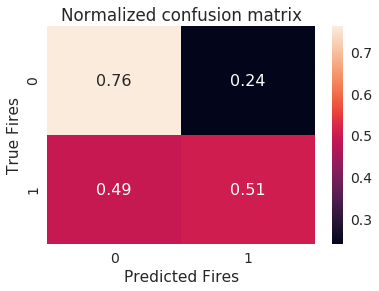

In [17]:
cm = confusion_matrix(y_test, y_pred) 
#normalize cm
array = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})#.set_title('Normalized confusion matrix')# font size
ax.set(xlabel='Predicted Fires', ylabel='True Fires', title = 'Normalized confusion matrix for ')
plt.show();

In [18]:
# it looks good so I'm going to try to save the entire pipeline:
from sklearn.externals import joblib

# save to Models Directory
joblib_file = 'Models/dtc_baseline_full.pkl'
joblib.dump(model, joblib_file)

['Models/dtc_baseline_full.pkl']

In [19]:
# now I'll reload it and calculate ROC
joblib_model = joblib.load(joblib_file)

joblib_model.score(X_test, y_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype uint8, uint16, float32 were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


0.6731734653372873

In [20]:
# aaaand that worked. Now I'll try it locally.